In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [2]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [3]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


The `train` DataFrame contains labeled data in four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails.

First: check if our data contains any missing values. 
-print the number of NaN values in each column
-If there are NaN values, we replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns will be replaced with empty strings) 
-Finally, we print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [4]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


In [5]:
#Looking at the first Ham and first Spam emails
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



First inspection, the spam has html formatting and no sign off

In [6]:
# This creates a 90/10 train-validation split on our labeled data

from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

Initial Feature Engineering

In [7]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    word_len = len(words)
    text_len = len(texts)
    indicator_array = np.array([texts.str.contains(word) for word in words]).T.astype(int)
    return indicator_array

Initial EDA - Frequency of potential words relevant to Spam Emails

Text(0, 0.5, 'Proportion of Email')

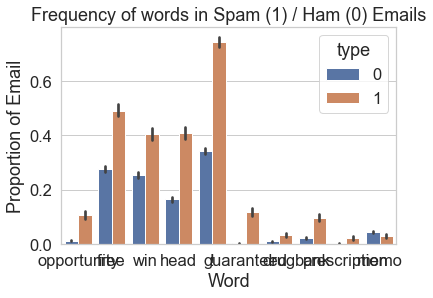

In [8]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

train_spam = train.loc[train["spam"] == 1, :]
train_ham = train.loc[train["spam"] == 0, :]
words_to_check = ["opportunity", "free", "win", "head", "!", "guaranteed",
                 "drug", "bank", "prescription", "memo", "private"]
check_series = words_in_texts(words_to_check, train.loc[:, "email"]).T
df_bar = pd.DataFrame({
    words_to_check[0]: check_series[0],
    words_to_check[1]: check_series[1],
    words_to_check[2]: check_series[2],
    words_to_check[3]: check_series[3],
    words_to_check[4]: check_series[4],
    words_to_check[5]: check_series[5],
    words_to_check[6]: check_series[6],
    words_to_check[7]: check_series[7],
    words_to_check[8]: check_series[8],
    words_to_check[9]: check_series[9],
    'type' : train.loc[:, "spam"]
})
df_bar = df_bar.melt('type')
sns.barplot(x=df_bar['variable'], y=df_bar['value'], hue=df_bar['type'])
plt.title("Frequency of words in Spam (1) / Ham (0) Emails")
plt.xlabel("Word")
plt.ylabel("Proportion of Email")

In [9]:
some_words = words_to_check

X_train = words_in_texts(some_words, train.loc[:, 'email'])
Y_train = train.loc[:, 'spam']

#Checking first 5 vals
X_train[:5], Y_train[:5]

(array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X=X_train, y=Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7931585252229469


Examples of precision, recall, and false-alarm rate

In [11]:
y_pred = model.predict(X_train)
all_positives = y_pred[y_pred == 1]
all_true = y_pred[y_pred == Y_train]
true_positives = all_true[all_true == 1]
all_false = y_pred[y_pred != Y_train]
false_negatives = all_false[all_false == 0]
false_positives = all_false[all_false == 1]
true_negatives = all_true[all_true == 0]
logistic_predictor_precision = len(true_positives) / len(all_positives)
logistic_predictor_recall = len(true_positives) / (len(true_positives) + len(false_negatives))
logistic_predictor_far = len(false_positives) / (len(false_positives) + len(true_negatives))
logistic_predictor_precision, logistic_predictor_recall, logistic_predictor_far

(0.6812749003984063, 0.35662148070907196, 0.05719392314566577)

In [12]:
train_spam = train.loc[train["spam"] == 1]
spam_dict = dict()
for line in train_spam["email"]:
    words = line.split()
    for word in words:
        to_add = word.split('/')
        for add in to_add:
            if len(add) < 20 and '-' not in add:
                if add not in spam_dict:
                    spam_dict[add] = 1
                else:
                    spam_dict[add] += 1
top = max(spam_dict, key=spam_dict.get)
print(max(spam_dict, key=spam_dict.get))
spam_dict.pop(top)
train_ham = train.loc[train["spam"] == 0]

the


In [13]:
top = max(spam_dict, key=spam_dict.get)
print(max(spam_dict, key=spam_dict.get))
spam_dict.pop(top)

19726

First our function to test our models once made

In [14]:
def test_model(model, x, y): 
    print(np.linalg.matrix_rank(x) == len(x.columns))
    model.fit(x, y)

    print(model.score(x, y))
    return model

Next our feature engineering

In [15]:
def feature_engineering(df, spam=True):
    if spam:
        X = df.drop(labels=["spam"], axis=1)
    else:
        X = df
        
    for col in ["subject", "email"]:
        X = check_for_words(X, col)
        X = num_char_word(X, col)
        X = count_punc(X, col)
        X = num_caps(X, col)
        X = num_letter(X, col, "!")
        X = num_letter(X, col, "#")
        X = num_letter(X ,col, "=")
        X = num_letter(X, col, "<")
        X = ratio_unique_words(X, col)
        X = X.drop(labels=col, axis=1)
    return X

def ratio_unique_words(df, col):
    series = []
    for row in df[col]:
        words = row.split()
        unique = set(words)
        if len(words) != 0:
            series.append(float(len(unique) / len(words)))
        else:
            series.append(0)
    df[f'{col} ratio_unique_words'] = series
    return df

def check_for_words(df, col):
    words = ["html", "guarenteed", "opportunity", "body", "please", "offer", "money", "girl", "sex", "drugs"
            "fee", "work", "home", "inheritance", "lottery", "visa", "enhancement", "dysfunctional", "dating",
            "military", "porn", "gift", "business", "Re", "won", "quick", "act", "now", "font", "helvetica", "http"
            "free", "image", "receive", "people", "send", "order"]
    data = words_in_texts(words, df[col])
    i = 0
    for word in words:
        df[f'{col} num_{word}'] = data[:, i]
        i += 1
    return df

def num_caps(df, col):
    caps = []
    for row in df[col]:
        caps.append(sum(1 for c in row if c.isupper()))
    df[f'{col} num_caps'] = caps
    return df

def num_letter(df, col, letter):
    caps = []
    for row in df[col]:
        caps.append(sum(1 for c in row if c == letter))
    df[f'{col} num_{letter}'] = caps
    return df

def count_punc(df, col):
    chars = ['!', '.', ';', '!!']
    
    data = words_in_texts(chars, df[col])
    i = 0
    for char in chars:
        df[f'{col} has_{char}'] = data[:, i]
        i += 1
    return df

def num_char_word(df, col):
    chars = []
    words = []
    for row in df[col]:
        chars.append(len(row))
        words.append(len(row.split()))
    df[f'{col} num_chars'] = chars
    df[f'{col} num_words'] = words
    return df

In [16]:
X_train, Y_train = feature_engineering(train), np.array(train["spam"])
model = test_model(LogisticRegression(max_iter=10000), X_train, Y_train)

False
0.9189405031279116


C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


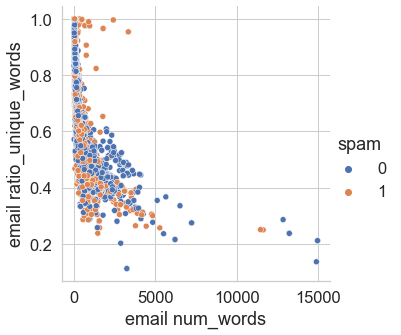

In [17]:
unique_words = ratio_unique_words(train, "email")
num_chars = num_char_word(unique_words, "email")
sns.relplot(
    data=num_chars, kind="scatter",
    x="email num_words", y="email ratio_unique_words",
    hue="spam", facet_kws=dict(sharex=False))

# sns.scatterplot(y=visualize["email num_words"], x=visualize["unique ratio"], hue=visualize["spam"])
# sns.lineplot(x=visualize['id'], y=visualize['unique ratio'], hue=visualize['spam'])
# sns.scatterplot(x=visualize['unique ratio'], hue=visualize['spam'])

ROC Curve

In [18]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(X_train)[:,1]
fpr, tpr, threshold = roc_curve(Y_train, 
                               y_score)

print("AUC = " + str(auc(fpr, tpr)))
      
# import plotly.express as px
# fig = px.line(x=fpr, y = tpr, hover_name=threshold)
# fig.update_xaxes(title="False Positive Rate")
# fig.update_yaxes(title="True Positive Rate")
# fig


AUC = 0.9587532999540591
